# Analyze sea-level predictions for Greenland by ISMIP6 and Aschwanden et al (2019) [AS19]

In [416]:
import numpy as np
import os
import pylab as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.colors as colors

from datetime import datetime
import time

In [417]:
hist_start = 2008
hist_end = 2014
proj_start = hist_end + 1
proj_end = 2100

Plotting helpers

In [418]:
fontsize = 8
lw = 0.65
aspect_ratio = 0.35
markersize = 2

params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.direction": "in",
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.direction": "in",
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
}

plt.rcParams.update(params)


secpera = 3.15569259747e7

grace_signal_lw = 0.75
mouginot_signal_lw = 0.75
imbie_signal_lw = 0.75
simulated_signal_lw = 0.3
grace_signal_color = "#084594"
grace_sigma_color = "#9ecae1"
mouginot_signal_color = "#a63603"
mouginot_sigma_color = "#fdbe85"
imbie_signal_color = "#005a32"
imbie_sigma_color = "#a1d99b"
mankoff_signal_color = "#54278f"
mankoff_sigma_color = "#bcbddc"
simulated_signal_color = "0.7"

gt2cmSLE = 1.0 / 362.5 / 10.0

rcp_list = ["26", "45", "85"]
rcp_col_dict = {"CTRL": "k", 85: "#990002", 45: "#5492CD", 26: "#003466"}


## Load ISMIP6 Greenland projections

In [419]:
ismip6 = pd.read_csv("ismip6_gris_ctrl_removed.csv.gz")

## ISMIP6 in numbers

In [420]:
ng = len(ismip6.groupby(by="Group").mean())
nm = len(ismip6.groupby(by="Model").mean())
ne = len(ismip6.groupby(by="Exp").mean())

print(f"Number of modeling groups participated: {ng}")
print(f"Number of ice sheet model configurations used: {nm}")
print(f"Number of experiments: {ne}")

Number of modeling groups participated: 13
Number of ice sheet model configurations used: 18
Number of experiments: 9


## Prepare GRACE time series

In [421]:
grace = pd.read_csv(
    "grace/greenland_mass_200204_202008.txt",
    header=30,
    delim_whitespace=True,
    skipinitialspace=True,
    names=["Year", "Cumulative ice sheet mass change (Gt)", "Cumulative ice sheet mass change uncertainty (Gt)"],
    )
# Normalize GRACE signal to the starting date of the projection
grace["Cumulative ice sheet mass change (Gt)"] -= np.interp(
    proj_start, grace["Year"], grace["Cumulative ice sheet mass change (Gt)"]
)

# Get the GRACE trend
grace_time = (grace["Year"] >= hist_start) & (grace["Year"] <= proj_start)
grace_hist_df = grace[grace_time]
x = grace_hist_df["Year"]
y = grace_hist_df["Cumulative ice sheet mass change (Gt)"]   
s = grace_hist_df["Cumulative ice sheet mass change uncertainty (Gt)"]
X = sm.add_constant(x)
ols = sm.OLS(y, X).fit()
p = ols.params
grace_bias = p[0]
grace_trend = p[1]
grace_trend_stderr = ols.bse[1]


## Prepare Aschwanden et al (2019) projections

In [422]:
as19_norm = pd.read_csv("as19/aschwanden_et_al_2019_les_2015_norm.csv.gz")
as19_norm["SLE (cm)"] = -as19_norm["Mass (Gt)"] / 362.5 / 10
as19_norm = as19_norm.astype({"RCP": int, "Experiment": int})

samples_file = "lhs_samples/lhs_samples_500.csv"
samples = pd.read_csv(samples_file).rename(columns={"id": "Experiment"})

as19_norm = pd.merge(as19_norm, samples, on="Experiment")


## Make a function to plot prognostic simulations

In [423]:
def plot_prognostic(ismip6, as19):
    """
    Plot model projections
    """

    xmin = -5
    xmax = 45
    
    fig, ax = plt.subplots(
        1,
        2,
        sharey="col",
        figsize=[6.2, 3.0],
        num="prognostic_all",
        clear=True,
        gridspec_kw=dict(width_ratios=[10, 1]),
    )
    fig.subplots_adjust(wspace=0.05)

    def plot_signal(g, *kwargs):

        return ax[0].plot(g[-1]["Year"], g[-1]["SLE (cm)"], zorder=-10, color="#8c510a", linewidth=0.5, alpha=0.1, *kwargs)

    # Plot each model response by grouping
    [plot_signal(g) for g in ismip6.groupby(by=["Group", "Model", "Exp", "RCP"])]

    sns.kdeplot(
        data=ismip6[ismip6["Year"] == 2100],
        y="SLE (cm)",
        common_grid=True,
        common_norm=True,
        color="#8c510a",
        linewidth=0.75,
        ax=ax[1],
    )

    l_ismip6 = mlines.Line2D([], [], color="#8c510a", linewidth=1.0, linestyle="solid", label="ISMIP6")
    l_as19 = mlines.Line2D([], [], color="#01665e", linewidth=1.0, linestyle="solid", label="AS19")
    
    legend_1 = ax[0].legend(handles=[l_ismip6], loc="upper left")
    legend_1.get_frame().set_linewidth(0.0)
    legend_1.get_frame().set_alpha(0.0)

    sns.despine(ax=ax[1], left=True, bottom=True)
    try:
        ax[1].get_legend().remove()
    except:
        pass
    ax[0].set_ylim(xmin, xmax)
    ax[1].set_ylim(xmin, xmax)
    ax[0].set_xlim(proj_start, proj_end)
    ax[1].set_xlabel(None)
    ax[1].set_ylabel(None)
    ax[1].axes.xaxis.set_visible(False)
    ax[1].axes.yaxis.set_visible(False)
    ax[0].set_xlabel("Year")
    ax[0].set_ylabel("SLE contribution (cm)")
    fig.savefig("GIS_ismip6_projection.pdf", bbox_inches="tight")
    
    g16 = ismip6.groupby(by=["Year"]).quantile(0.16).reset_index()
    g50 = ismip6.groupby(by=["Year"]).quantile(0.5).reset_index()
    g84 = ismip6.groupby(by=["Year"]).quantile(0.84).reset_index()
    # Percentiles at 2100
    p16 = g16[g16["Year"] == 2100]["SLE (cm)"].values[-1]
    p50 = g50[g50["Year"] == 2100]["SLE (cm)"].values[-1]
    p84 = g84[g84["Year"] == 2100]["SLE (cm)"].values[-1]
    
    ax[0].fill_between(g50["Year"], g16["SLE (cm)"], g84["SLE (cm)"], color="#bf812d", linewidth=1.0, alpha=1.0,)
    ax[0].plot(g16["Year"], g16["SLE (cm)"], color="#8c510a", linewidth=0.25, alpha=1.0,)
    ax[0].plot(g50["Year"], g50["SLE (cm)"], color="#8c510a", linewidth=1.0, alpha=1.0,)
    ax[0].plot(g84["Year"], g84["SLE (cm)"], color="#8c510a", linewidth=0.25, alpha=1.0,)
    
    ax[1].axhline(p16, color="#8c510a", linewidth=0.5, alpha=1.0,)
    ax[1].axhline(p50, color="#8c510a", linewidth=1.0, alpha=1.0,)
    ax[1].axhline(p84, color="#8c510a", linewidth=0.5, alpha=1.0,)
    ax[1].annotate(np.round(p16, 0), (0.13, p16), color="#8c510a", xycoords="data")
    ax[1].annotate(np.round(p50, 0), (0.13, p50), color="#8c510a", xycoords="data")
    ax[1].annotate(np.round(p84, 0), (0.13, p84), color="#8c510a", xycoords="data")

    fig.savefig("GIS_ismip6_projection_stats.pdf", bbox_inches="tight", pad_inches=0.1)


    def plot_signal(g, *kwargs):

        return ax[0].plot(g[-1]["Year"], g[-1]["SLE (cm)"], zorder=-9, color="#01665e", linewidth=0.5, alpha=0.1, *kwargs)

    # Plot each model response by grouping
    [plot_signal(g) for g in as19.groupby(by=["Experiment", "RCP"])]
    g16 = as19.groupby(by=["Year"]).quantile(0.16).reset_index()
    g50 = as19.groupby(by=["Year"]).quantile(0.5).reset_index()
    g84 = as19.groupby(by=["Year"]).quantile(0.84).reset_index()
    # Percentiles at 2100
    p16 = g16[g16["Year"] == 2100]["SLE (cm)"].values[-1]
    p50 = g50[g50["Year"] == 2100]["SLE (cm)"].values[-1]
    p84 = g84[g84["Year"] == 2100]["SLE (cm)"].values[-1]

    
    ax[0].fill_between(g50["Year"], g16["SLE (cm)"], g84["SLE (cm)"], color="#35978f", linewidth=1.0, alpha=1.0,)
    ax[0].plot(g16["Year"], g16["SLE (cm)"], color="#01665e", linewidth=0.25, alpha=1.0,)
    ax[0].plot(g50["Year"], g50["SLE (cm)"], color="#01665e", linewidth=1.0, alpha=1.0,)
    ax[0].plot(g84["Year"], g84["SLE (cm)"], color="#01665e", linewidth=0.25, alpha=1.0,)

    ax[1].axhline(p16, color="#01665e", linewidth=0.5, alpha=1.0,)
    ax[1].axhline(p50, color="#01665e", linewidth=1.0, alpha=1.0,)
    ax[1].axhline(p84, color="#01665e", linewidth=0.5, alpha=1.0,)

    ax[1].annotate(np.round(p16, 0), (0.13, p16), color="#01665e", xycoords="data")
    ax[1].annotate(np.round(p50, 0), (0.13, p50), color="#01665e", xycoords="data")
    ax[1].annotate(np.round(p84, 0), (0.13, p84), color="#01665e", xycoords="data")
    
    sns.kdeplot(
        data=as19[as19["Year"] == 2100],
        y="SLE (cm)",
        common_grid=True,
        common_norm=True,
        color="#01665e",
        linewidth=0.75,
        ax=ax[1],
    )

    legend_1 = ax[0].legend(handles=[l_ismip6, l_as19], loc="upper left")
    legend_1.get_frame().set_linewidth(0.0)
    legend_1.get_frame().set_alpha(0.0)

    fig.savefig("GIS_ismip6_as19_projection.pdf", bbox_inches="tight")
    
    del fig




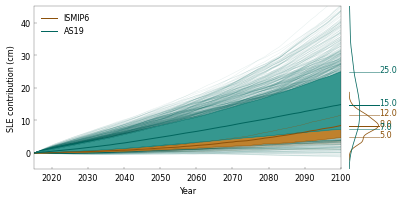

In [424]:
plot_prognostic(ismip6, as19_norm)

## Comparison between ISMIP6 and AS19

ISMIP 6 illustrates the *model uncertainty*
<img src="GIS_ismip6_projection.pdf">
AS19 illustrates the *parametric uncertainty*
<img src="GIS_ismip6_as19_projection.pdf">
It becomes obvious that *parametric uncertainty* is larger than *model uncertainty*

## Let's load some more observations

In [425]:
    imbie_df = pd.read_excel(
        "imbie/imbie_dataset_greenland_dynamics-2020_02_28.xlsx", sheet_name="Greenland Ice Mass", engine="openpyxl"
    )
    imbie = imbie_df[
        [
            "Year",
            "Cumulative ice sheet mass change (Gt)",
            "Cumulative ice sheet mass change uncertainty (Gt)",
            "Cumulative surface mass balance anomaly (Gt)",
            "Cumulative surface mass balance anomaly uncertainty (Gt)",
            "Cumulative ice dynamics anomaly (Gt)",
            "Cumulative ice dynamics anomaly uncertainty (Gt)",
            "Rate of mass balance anomaly (Gt/yr)",
            "Rate of ice dynamics anomaly (Gt/yr)",
            "Rate of mass balance anomaly uncertainty (Gt/yr)",
            "Rate of ice dyanamics anomaly uncertainty (Gt/yr)",
        ]
    ].rename(
        columns={
            "Rate of mass balance anomaly (Gt/yr)": "Rate of surface mass balance anomaly (Gt/yr)",
            "Rate of mass balance anomaly uncertainty (Gt/yr)": "Rate of surface mass balance anomaly uncertainty (Gt/yr)",
            "Rate of ice dyanamics anomaly uncertainty (Gt/yr)": "Rate of ice dynamics anomaly uncertainty (Gt/yr)",
        }
    )

    for v in [
        "Cumulative ice sheet mass change (Gt)",
        "Cumulative ice dynamics anomaly (Gt)",
        "Cumulative surface mass balance anomaly (Gt)",
    ]:
        imbie[v] -= imbie[imbie["Year"] == proj_start][v].values

    s = imbie[(imbie["Year"] >= 1980) & (imbie["Year"] < 1990)]
    mass_mean = s["Cumulative ice sheet mass change (Gt)"].mean() / (1990 - 1980)
    smb_mean = s["Cumulative surface mass balance anomaly (Gt)"].mean() / (1990 - 1980)
    imbie[f"Rate of surface mass balance anomaly (Gt/yr)"] += 2 * 1964 / 10
    imbie[f"Rate of ice dynamics anomaly (Gt/yr)"] -= 2 * 1964 / 10

    mou19_df = pd.read_excel(
        "mouginot/pnas.1904242116.sd02.xlsx", sheet_name="(2) MB_GIS", header=8, usecols="B,AR:BJ", engine="openpyxl"
    )
    mou19_d = mou19_df.iloc[7]
    mou19_smb = mou19_df.iloc[19]
    mou19_mass = mou19_df.iloc[41]
    mou19 = pd.DataFrame(
        data=np.hstack(
            [
                mou19_df.columns[1::].values.reshape(-1, 1),
                mou19_mass.values[1::].reshape(-1, 1),
                np.cumsum(mou19_smb.values[1::]).reshape(-1, 1),
                -np.cumsum(mou19_d.values[1::]).reshape(-1, 1),
                mou19_smb.values[1::].reshape(-1, 1),
                -mou19_d.values[1::].reshape(-1, 1),
            ]
        ),
        columns=[
            "Year",
            "Cumulative ice sheet mass change (Gt)",
            "Cumulative surface mass balance anomaly (Gt)",
            "Cumulative ice dynamics anomaly (Gt)",
            "Rate of surface mass balance anomaly (Gt/yr)",
            "Rate of ice dynamics anomaly (Gt/yr)",
        ],
    )
    mou19 = mou19.astype(
        {
            "Year": float,
            "Cumulative ice sheet mass change (Gt)": float,
            "Cumulative surface mass balance anomaly (Gt)": float,
            "Cumulative ice dynamics anomaly (Gt)": float,
            "Rate of surface mass balance anomaly (Gt/yr)": float,
            "Rate of ice dynamics anomaly (Gt/yr)": float,
        }
    )

    # Normalize
    for v in [
        "Cumulative ice sheet mass change (Gt)",
        "Cumulative ice dynamics anomaly (Gt)",
        "Cumulative surface mass balance anomaly (Gt)",
    ]:
        mou19[v] -= mou19[mou19["Year"] == proj_start][v].values

    man_d = pd.read_csv("mankoff/GIS_D.csv", parse_dates=[0])
    man_d["Year"] = [toYearFraction(d) for d in man_d["Date"]]
    man_d = man_d.astype({"Discharge [Gt yr-1]": float})
    man_err = pd.read_csv("mankoff/GIS_err.csv", parse_dates=[0])
    man_err["Year"] = [toYearFraction(d) for d in man_err["Date"]]
    man_err = man_err.astype({"Discharge Error [Gt yr-1]": float})
    man = pd.merge(man_d, man_err, on="Year").drop(columns=["Date_x", "Date_y"])


In [426]:
def calculate_model_trends(df, obs_trend, tolerance):
    """
    Calculate the historical model trends and decided if agrees with Observations
    with a given tolerance.
    """
    groups = []
    models = []
    exps = []
    trends = []
    sigmas = []
    for g in df.groupby(by=["Group", "Model", "Exp"]):
        m_df = g[-1][(g[-1]["Year"] >= hist_start) & (g[-1]["Year"] <= proj_start)]
        x = m_df["Year"]
        y = m_df["Cumulative ice sheet mass change (Gt)"]
        X = sm.add_constant(x)
        ols = sm.OLS(y, X).fit()
        p = ols.params
        model_bias = p[0]
        model_trend = p[1]
        model_trend_sigma = ols.bse[-1]
        groups.append(g[0][0])
        models.append(g[0][1])
        exps.append(g[0][2])
        trends.append(model_trend)
        sigmas.append(model_trend_sigma)

    model_trends = pd.DataFrame(
        data=np.hstack(
            [
                np.array(groups).reshape(-1, 1),
                np.array(models).reshape(-1, 1),
                np.array(exps).reshape(-1, 1),
                np.array(trends).reshape(-1, 1),
                np.array(sigmas).reshape(-1, 1),
            ]
        ),
        columns=["Group", "Model", "Exp", "Trend (Gt/yr)", "Sigma (Gt/yr)"],  # "Meet_Threshold"],
    )
    model_trends = model_trends.astype(
        {"Group": str, "Model": str, "Exp": str, "Trend (Gt/yr)": float, "Sigma (Gt/yr)": float}
    )
    model_trends = model_trends.groupby(by=["Group", "Model"]).mean(numeric_only=False).reset_index()
    model_trends["Meet_Threshold"] = np.abs(1 - model_trends["Trend (Gt/yr)"] / obs_trend) <= tolerance
    # Create unique ID column Group-Model
    model_trends["Group-Model"] = model_trends["Group"] + "-" + model_trends["Model"]
    return model_trends

In [427]:
def plot_historical(out_filename, df, grace, mou19, imbie, model_trends):
    """
    Plot historical simulations and the GRACE signal.
    """

    def plot_signal(g):
        m_df = g[-1]
        x = m_df["Year"]
        y = m_df["Cumulative ice sheet mass change (Gt)"]

        return ax.plot(x, y, color=simulated_signal_color, linewidth=simulated_signal_lw)

    xmin = 2000
    xmax = 2025
    ymin = -3000
    ymax = 4000

    fig = plt.figure(num="historical", clear=True)
    ax = fig.add_subplot(111)

    [plot_signal(g) for g in df.groupby(by=["Group", "Model", "Exp"])]

    # Plot GRACE
    ax.fill_between(
        mou19["Year"],
        (1 - 0.057) * mou19["Cumulative ice sheet mass change (Gt)"],
        (1 + 0.057) * mou19["Cumulative ice sheet mass change (Gt)"],
        color=mouginot_sigma_color,
        alpha=0.5,
        linewidth=0,
    )
    mou19_line = ax.plot(
        mou19["Year"],
        mou19["Cumulative ice sheet mass change (Gt)"],
        "-",
        color=mouginot_signal_color,
        linewidth=mouginot_signal_lw,
        label="Observed (Mouginot et al, 2019)",
    )

    ax.fill_between(
        imbie["Year"],
        imbie["Cumulative ice sheet mass change (Gt)"]
        - 1 * imbie["Cumulative ice sheet mass change uncertainty (Gt)"],
        imbie["Cumulative ice sheet mass change (Gt)"]
        + 1 * imbie["Cumulative ice sheet mass change uncertainty (Gt)"],
        color=imbie_sigma_color,
        alpha=0.5,
        linewidth=0,
    )
    imbie_line = ax.plot(
        imbie["Year"],
        imbie["Cumulative ice sheet mass change (Gt)"],
        "-",
        color=imbie_signal_color,
        linewidth=imbie_signal_lw,
        label="Observed (IMBIE)",
    )

    ax.fill_between(
        grace["Year"],
        grace["Cumulative ice sheet mass change (Gt)"]
        - 1 * grace["Cumulative ice sheet mass change uncertainty (Gt)"],
        grace["Cumulative ice sheet mass change (Gt)"]
        + 1 * grace["Cumulative ice sheet mass change uncertainty (Gt)"],
        color=grace_sigma_color,
        alpha=0.5,
        linewidth=0,
    )
    grace_line = ax.plot(
        grace["Year"],
        grace["Cumulative ice sheet mass change (Gt)"],
        "-",
        color=grace_signal_color,
        linewidth=grace_signal_lw,
        label="Observed (GRACE)",
    )
    ax.axvline(proj_start, color="k", linestyle="dashed", linewidth=grace_signal_lw)
    ax.axhline(0, color="k", linestyle="dotted", linewidth=grace_signal_lw)
    ax.text(2014.75, 3000, "Historical Period", ha="right")
    ax.text(2015.25, 3000, "Projection Period", ha="left")

    model_line = mlines.Line2D([], [], color=simulated_signal_color, linewidth=simulated_signal_lw, label="Simulated")

    legend = ax.legend(handles=[grace_line[0], mou19_line[0], imbie_line[0], model_line], loc="lower left")
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)

    ax.set_xlabel("Year")
    ax.set_ylabel(f"Cumulative mass change\nsince {proj_start} (Gt)")

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax_sle = ax.twinx()
    ax_sle.set_ylabel(f"Contribution to sea-level \nsince {proj_start} (cm SLE)")
    ax_sle.set_ylim(-ymin * gt2cmSLE, -ymax * gt2cmSLE)

    set_size(5, 2)

    fig.savefig(out_filename, bbox_inches="tight")


## Calculate model trends

and assess if trend is within +/- tolerance * observational trend

In [429]:
tolerance = 0.25
model_trends = calculate_model_trends(ismip6, grace_trend, tolerance)

## Now plot the historical simulations along side observations

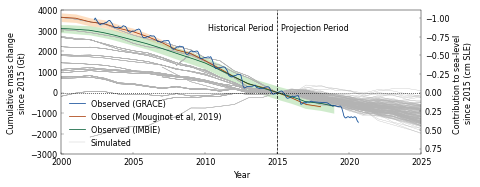

In [430]:
plot_historical(f"{d}_historical.pdf", ismip6, grace, mou19, imbie, model_trends)

Unfortunately, very few historical simulations capture contemporary mass loss. This is a huge concern, as under-estimating contemporary mass loss is likley to translate into under-estimating future mass loss.